In [2]:
# Connect to google drive where data is stored
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries and Reading in Data

In [3]:
# Import Necessary Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import os
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [4]:
# Set working directory
desired_directory = '/content/drive/MyDrive/Colab Notebooks/SignLanguage/'
os.chdir(desired_directory)

In [5]:
# Load data
train = pd.read_csv("sign_mnist_train.csv")
test = pd.read_csv("sign_mnist_test.csv")

train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


## Visualizing Training Data

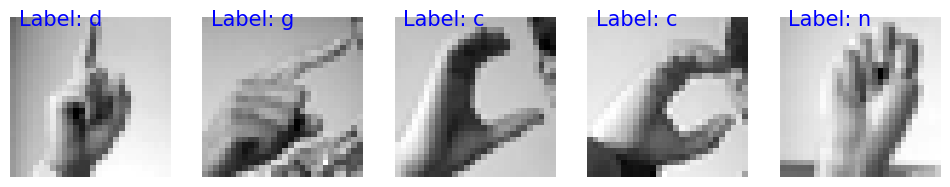

In [7]:
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
label_mapping = {i: chr(ord('a') + i) for i in range(26)}

for i in range(5):
    axes[i].imshow(train.iloc[i][1:].values.reshape(28,28,1), cmap='gray')
    axes[i].axis('off')
    label_letter = label_mapping[train["label"][i]]
    axes[i].text(1, 1, f"Label: {label_letter}", color='blue', fontsize=15)
plt.show()

## Implementing Data Augmentation

Here we augment the data by rotating, shifting (horizontal and vertical), and zooming.

In [9]:
data_augmentation = ImageDataGenerator(
    rotation_range=10,  # apply up to 10 degrees rotation randomly
    width_shift_range=0.1,  # randomly shift images 10% of the width
    height_shift_range=0.1,  # randomly shift images 10% of the height
    zoom_range=0.1,  # randomly zoom into images up to 10%
    horizontal_flip=False,  # do not flip images horizontally (sign language is not read with hands horizontally flipped)
    fill_mode='nearest'  # fill empty pixels with 'nearest' mode
)


## Data Check

In sign language some letters cannot be signed with just an image because they require motion as a part of the letter. These letters are J and Z. Because of this we need to update the indexing for all the letters above index 9 and shift each of them down by 1.

In [80]:
train["label"].value_counts().index.sort_values()

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23],
           dtype='int64')

In [6]:
# decrease letter index by 1 if index is greater than or equal to 10 in both test and train set
train["label"][train["label"]>=10] = train["label"] -1
test["label"][test["label"]>=10] = test["label"] -1

In [7]:
# Check shape and resize
print("Raw Data Shape:")
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

# create data and label sets for training
train_data = train.drop("label", axis = 1)
train_labels = train['label']
train_data = np.array(train_data)

# create data and label sets for testing
test_data = test.drop("label", axis = 1)
test_labels = test['label']
test_data = np.array(test_data)


# split training data into train and validation
train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.2, random_state=982
)

# normalize the data so the pixels range from [0-1]
train_data = train_data/255
val_data = val_data/255
test_data = test_data/255

# print the shape of the data and label arrays
print("\nAfter Splitting into X and y:")
print("Test Data Shape:", train_data.shape)
print("Test Labels Shape:", train_labels.shape)
print("Validation Data Shape:", val_data.shape)
print("Validation Labels Shape:", val_labels.shape)
print("Test Data Shape:", test_data.shape)
print("Test Labels Shape:", test_labels.shape)


# reshape images to 28x28 for CNN input
train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
val_data = val_data.reshape(val_data.shape[0], 28, 28, 1)
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)

# print the data after reshaping to 28x28
print("\nAfter Reshaping Data:")
print("Train Data Shape:", train_data.shape)
print("Train Labels Shape:", train_labels.shape)
print("Validation Data Shape:", val_data.shape)
print("Validation Labels Shape:", val_labels.shape)
print("Test Data Shape:", test_data.shape)
print("Test Labels Shape:", test_labels.shape)

Raw Data Shape:
Train Shape: (27455, 785)
Test Shape: (7172, 785)

After Splitting into X and y:
Test Data Shape: (21964, 784)
Test Labels Shape: (21964,)
Validation Data Shape: (5491, 784)
Validation Labels Shape: (5491,)
Test Data Shape: (7172, 784)
Test Labels Shape: (7172,)

After Reshaping Data:
Train Data Shape: (21964, 28, 28, 1)
Train Labels Shape: (21964,)
Validation Data Shape: (5491, 28, 28, 1)
Validation Labels Shape: (5491,)
Test Data Shape: (7172, 28, 28, 1)
Test Labels Shape: (7172,)


## Class Distributions of 3 Datasets

The class distributions in the Train and Validation sets are approximatly equal. The test dataset distribution is somewhat different, but this is to be expected given the smaller amount of data in this set.

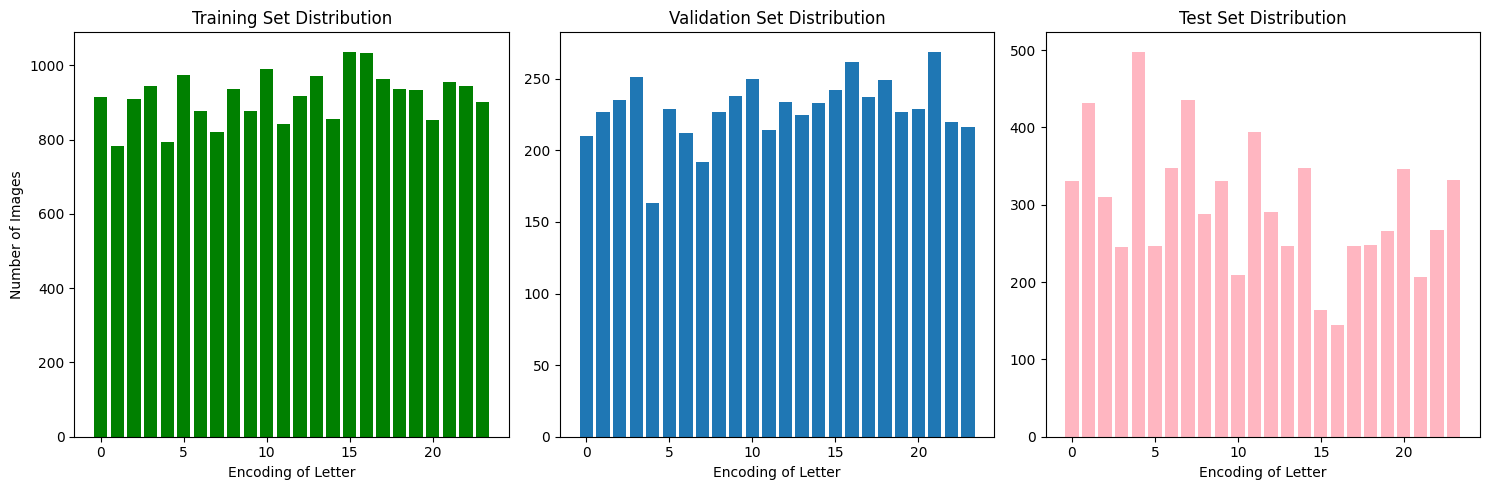

In [85]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)

# plot training data
plt.bar(np.unique(train_labels, return_counts=True)[0], np.unique(train_labels, return_counts=True)[1], color = "green")
plt.ylabel("Number of Images")
plt.xlabel("Encoding of Letter")
plt.title('Training Set Distribution')


# plot validation data
plt.subplot(1, 3, 2)
plt.bar(np.unique(val_labels, return_counts=True)[0], np.unique(val_labels, return_counts=True)[1])
plt.title('Validation Set Distribution')
plt.xlabel("Encoding of Letter")

# plot test data
plt.subplot(1, 3, 3)
plt.bar(np.unique(test_labels, return_counts=True)[0], np.unique(test_labels, return_counts=True)[1], color = "lightpink")
plt.title('Test Set Distribution')
plt.xlabel("Encoding of Letter")

plt.tight_layout()
plt.show()

In [26]:
### convert y values to categorical NOT NEEDED WHEN USING "sparse_categorical_crossentropy"
#train_labels = keras.utils.to_categorical(train_labels, num_classes=24)
#val_labels = keras.utils.to_categorical(val_labels, num_classes=24)
#test_labels = keras.utils.to_categorical(test_labels, num_classes=24)

## Model Developement

In [88]:

K.clear_session() # restart tensorflow session
tf.random.set_seed(142) # set a random seed for reproducability

# define CNN architecture
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)), # 2D convolutional layer with 3x3 kernel, 32 filters, and relu activation
    layers.MaxPooling2D((2, 2)), # max pooling layer with 2x2 window
    layers.Conv2D(64, (3, 3), activation='relu'),  # 2D convolutional layer with 3x3 kernel, 64 filters, and relu activation
    layers.MaxPooling2D((2, 2)),  # max pooling layer with 2x2 window
    layers.Flatten(), # flatten previous layer outputs to feed into mlp
    layers.Dense(128, activation='relu'), # dense layer with 128 input nodes and relu activation
    #Dropout(0.5),  # Add dropout with a dropout rate of 0.5
    layers.Dense(24, activation='softmax') # dense output layer with 24 outputs (24 classes) using softmax activation
])
opt = keras.optimizers.Adam(learning_rate=.001) # define the optimizer (here the optimal chose is adam with learning rate = 0.001)
model.compile(opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) # compile the model using sparse_categorical_crossentropy as loss

# define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # stop the training if model does not improve val_loss after 3 epochs
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True) # save and checkpoint the best model

# train the model and save results
history = model.fit(
    data_augmentation.flow(train_data, train_labels, batch_size=16), epochs=20, # here we implement the data augmentation with the training data
    validation_data=(val_data, val_labels), callbacks=[early_stopping, model_checkpoint]
)



Epoch 1/20
1373/1373 [==============================] - 12s 8ms/step - loss: 1.4844 - accuracy: 0.5431 - val_loss: 0.3644 - val_accuracy: 0.8803
Epoch 2/20
1373/1373 [==============================] - 10s 8ms/step - loss: 0.5087 - accuracy: 0.8361 - val_loss: 0.1453 - val_accuracy: 0.9583
Epoch 3/20
1373/1373 [==============================] - 11s 8ms/step - loss: 0.3016 - accuracy: 0.9002 - val_loss: 0.0664 - val_accuracy: 0.9822
Epoch 4/20
1373/1373 [==============================] - 10s 8ms/step - loss: 0.2204 - accuracy: 0.9262 - val_loss: 0.0565 - val_accuracy: 0.9822
Epoch 5/20
1373/1373 [==============================] - 10s 8ms/step - loss: 0.1654 - accuracy: 0.9462 - val_loss: 0.0335 - val_accuracy: 0.9880
Epoch 6/20
1373/1373 [==============================] - 10s 7ms/step - loss: 0.1326 - accuracy: 0.9576 - val_loss: 0.0210 - val_accuracy: 0.9940
Epoch 7/20
1373/1373 [==============================] - 11s 8ms/step - loss: 0.1156 - accuracy: 0.9618 - val_loss: 0.0127 - val_ac

## Model Evaluation

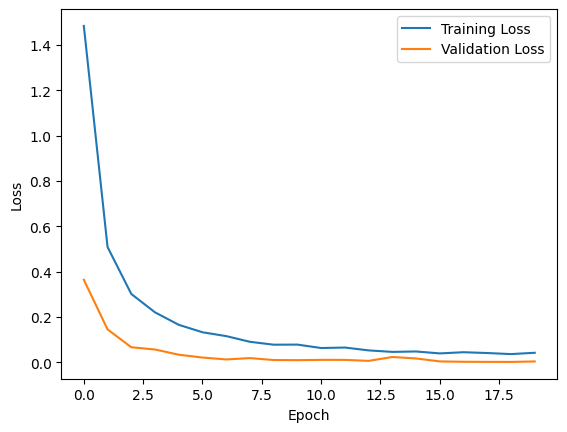

In [89]:
# plot training and validation loss over the training period
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose = 0)
print(f'Test accuracy: {test_acc}')

# make predictions
predictions = model.predict(test_data, verbose = 0)
predicted_labels = np.argmax(predictions, axis=1)


Test accuracy: 0.9965142011642456


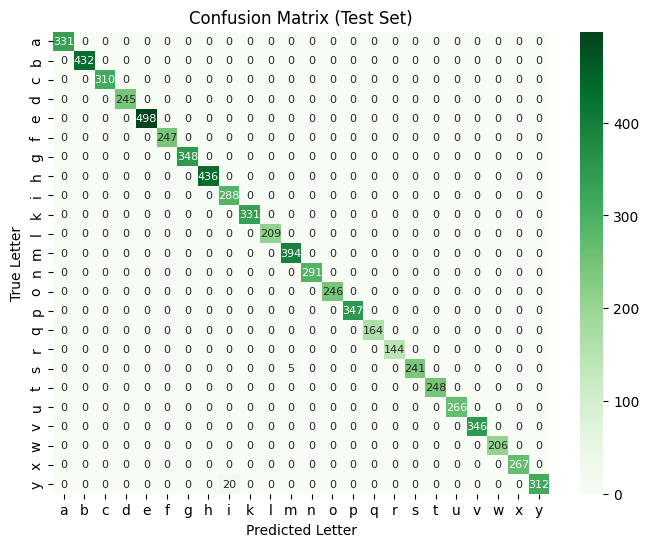

In [30]:
# mapping function for label index to true alphabetical character
index_to_letter = {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'k', 10: 'l', 11: 'm', 12: 'n', 13: 'o', 14: 'p', 15: 'q', 16: 'r', 17: 's', 18: 't', 19: 'u', 20: 'v', 21: 'w', 22: 'x', 23: 'y'}

# heatmap of test set predictions
conf_matrix = confusion_matrix(np.array(test_labels), predicted_labels)
plt.figure(figsize=(8, 6))
fig = sns.heatmap(conf_matrix, annot=True, fmt='d',annot_kws={'fontsize': 8}, cmap='Greens', xticklabels=index_to_letter.values(), yticklabels=index_to_letter.values())
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Letter')
plt.ylabel('True Letter')
plt.show()

In [20]:
# model.save("sign_language_model.keras")

## Testing the new model

In [8]:
# load best model
model = load_model("sign_language_model.keras")

In [10]:
# mapping function for label index to true alphabetical character
index_to_letter = {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'k', 10: 'l', 11: 'm', 12: 'n', 13: 'o', 14: 'p', 15: 'q', 16: 'r', 17: 's', 18: 't', 19: 'u', 20: 'v', 21: 'w', 22: 'x', 23: 'y'}

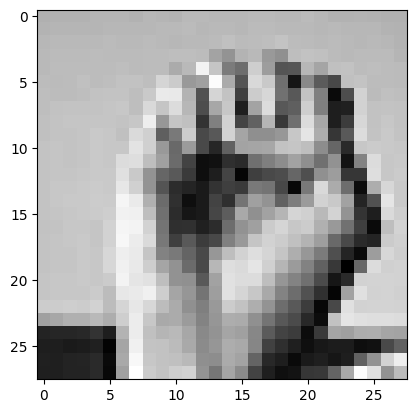

1/1 [==============================] - 0s 44ms/step


Image 172: 
----------
True Label = 'e' 
Predicted Label = 'e'


In [31]:
# random test image
image_num = 172
plt.imshow(test.iloc[image_num][1:].values.reshape(28,28,1), cmap='gray')
plt.show()

# reshape and normalize test image
img = np.array(test.iloc[image_num][1:])
img = img.reshape(1,28,28,1)
img = img/255

# make prediction on test image
prediction = np.argmax(model.predict(img), axis = 1 )[0]
pred_letter = index_to_letter[prediction]
# return true prediction
true_letter = index_to_letter[test.iloc[image_num][0]]

print(f"\n\nImage {image_num}: \n----------\nTrue Label = '{true_letter}' \nPredicted Label = '{pred_letter}'")